(sec:agent)=
# Agent-based modeling

An [agent-based model](https://en.wikipedia.org/wiki/Agent-based_model) (ABM) is a computational model for simulating the actions and interactions of autonomous agents (both individual or collective entities such as organizations or groups) in order to understand the behavior of a system and what governs its outcomes.

ABMs are created to simulate the seemingly stochastic behavior of microscopic individuals to build up and predict the appearance of complex macroscopic phenomena. Most agent-based models are composed of: (1) numerous agents specified at various scales (typically referred to as agent-granularity); (2) decision-making heuristics; (3) learning rules or adaptive processes; (4) an interaction topology; and (5) an environment.

The use and advancements of ABMs is promoted by the increasing computational power of modern computers and there is a natural appeal in explaining macroscopic phenomena from microscopic interactions. There may be a risk, however, of not seeing the forest for all the trees as the complexity of decision-makinng can be increased.

## Mesa

[Mesa](https://mesa.readthedocs.io/en/stable/overview.html) is a Python framework for agent-based modeling. It contains three categories of modules:

1. **Modeling**: Modules used to build the models themselves: a model and agent classes, a scheduler to determine the sequence in which the agents act, and space for them to move around on.

2. **Analysis**: Tools to collect data generated from your model, or to run it multiple times with different parameter values.

3. **Visualization**: Classes to create and launch an interactive model visualization, using a server with a JavaScript interface.

Every ABM requires two classes, one for the overall model and one for the agents. These classes will be derived classes of Mesa's base classes `Model` and `Agent`. The model class holds the model-level attributes, manages the agents, and generally handles the global level of our model. Each instantiation of the model class will be a specific model run. Each model will contain multiple agents, all of which are instantiations of the agent class.

In [1]:
# Modeling
from mesa import Agent, Model

# Analysis
from mesa.datacollection import DataCollector
from mesa.space import MultiGrid
from mesa.time import RandomActivation

### Model
Our model will be that of $N$ agents randomly walking around in a 2D landscape grid of cells. To begin with, the agents are randomly positioned. The model defines a data collector that in each time step records the wealth of agents and an overall indicator for wealth distribution.

In [6]:
class MoneyModel(Model):
    def __init__(self, N, width, height):
        # run the __init__ method of the parent class
        super().__init__()
        # additional initialization for the derived class
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(
            model_reporters={
                "Gini coefficient": compute_gini  # function defined below
            },
            agent_reporters={
                "Agent wealth": "wealth",
                "Agent position": "pos",
            },  # agent attributes
        )

        # Create agents
        for unique_id in range(self.num_agents):
            agent = MoneyAgent(unique_id, self)
            self.schedule.add(agent)

            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(agent, (x, y))

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

### Agent
Every agent starts with a wealth of 1. If an agent has nonzero wealth and enters into a non-empty cell, the agent will give one unit of wealth to a random cellmate.

In [7]:
class MoneyAgent(Agent):
    def __init__(self, unique_id, model):
        # run the __init__ method of the parent class
        super().__init__(unique_id, model)
        # additional initialization for the derived class
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,  # current position
            moore=True,  # including step on the diagonal
            include_center=False,  # to remain at current position is not allowed
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

As metric indicator of wealth distribution, we implement the [Gini coefficient](https://en.wikipedia.org/wiki/Gini_coefficient). Let $x_i$ for $i = 1,\ldots, N$ be the wealth of $N$ individuals ordered such that $x_i \leq x_{i+1}$. The Gini coefficient for this population is

$$
G = \frac{1}{N}
\Big(
N + 1 - \frac{2}{X} \sum_{i=1}^N (N+1-i) x_i
\Big)
$$

where $X$ is the sum of wealths, or, in other words, the total population wealth. There are two limting values for $G$. If every individual has the same wealth, then $G = 0$. If the total population wealth belongs to a single individual, then $G = (1 - 1/N)$.

In [8]:
def compute_gini(model):
    N = model.num_agents

    # collect wealth of agent into a list and sort it in increasing order
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)

    # calculate the Gini coefficient
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / sum(x)
    G = (N + 1 - 2 * B) / N

    return G

### Running the simulation
We run the model with 50 agents distributed in a 10 $\times$ 10 grid of cells for 100 time steps.

In [9]:
model = MoneyModel(50, 10, 10)

for i in range(100):
    model.step()

### Collecting stored data
After the simulation, we collect the model and agent data that are stored using the [Pandas](https://pandas.pydata.org/docs/getting_started/overview.html) `DataFrame` data structure.

In [10]:
model_df = model.datacollector.get_model_vars_dataframe()
agent_df = model.datacollector.get_agent_vars_dataframe()

We expose the data structures with use of the methods `head(n)` and `tail(n)` showing, respectively, the first and last *n* rows of the dataframe. A regular `print` statements can also be used.

In [11]:
model_df.head(5)

,Gini coefficient
0,0.0000
1,0.2112
2,0.3328
3,0.4488
4,0.5160


In [12]:
agent_df.tail(4)

Agent wealth Agent position
Step AgentID                             
99   17                  0         (7, 0)
     13                  2         (0, 6)
     26                  0         (9, 8)
     7                   0         (8, 1)

In [13]:
print(agent_df)

              Agent wealth Agent position
Step AgentID                             
0    0                   1         (2, 3)
     1                   1         (3, 0)
     2                   1         (1, 8)
     3                   1         (5, 3)
     4                   1         (9, 3)
...                    ...            ...
99   35                  0         (4, 4)
     17                  0         (7, 0)
     13                  2         (0, 6)
     26                  0         (9, 8)
     7                   0         (8, 1)

[5000 rows x 2 columns]


### Plotting results

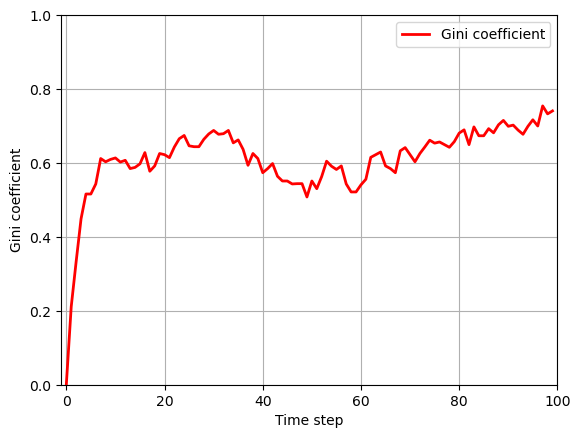

In [14]:
import matplotlib.pyplot as plt

model_df.plot(color="r", lw=2)

plt.ylabel("Gini coefficient")
plt.xlabel("Time step")
plt.grid("on")
plt.setp(plt.gca(), xlim=(-1, 100), ylim=(0, 1))

plt.show()

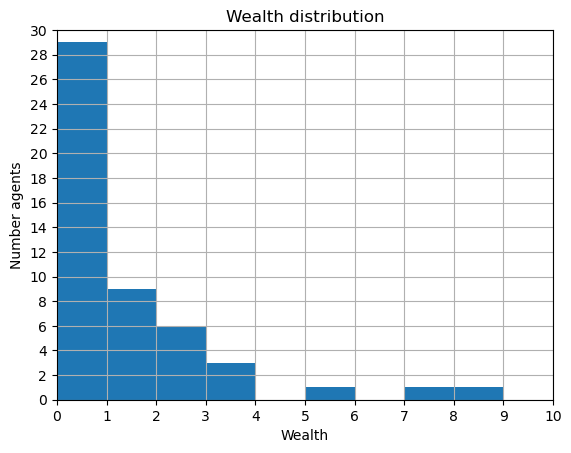

In [15]:
# extract a cross section of the dataframe for the final time step
final_wealth_df = agent_df.xs(99, level="Step")

# plot a histogram
final_wealth_df.hist(bins=range(11))

plt.title("Wealth distribution")
plt.ylabel("Number agents")
plt.xlabel("Wealth")
plt.setp(
    plt.gca(), xlim=(0, 10), xticks=range(11), ylim=(0, 30), yticks=range(0, 31, 2)
)

plt.show()

Let us find the agent that accumulated maximum wealth and the time step at which this occured.

In [16]:
step_idx, agent_idx = agent_df.idxmax().iloc[0]

print("Agent:", agent_idx)
print("Step:", step_idx)

Agent: 5
Step: 88


Let us plot the time series of wealth for this agent.

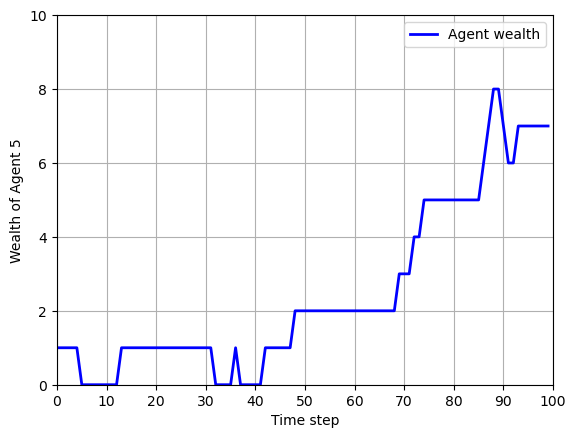

In [17]:
one_agent_wealth_df = agent_df.xs(agent_idx, level="AgentID")

one_agent_wealth_df.plot(lw=2, color="b")

plt.ylabel(f"Wealth of Agent {agent_idx}")
plt.xlabel("Time step")

plt.grid(True)
plt.setp(
    plt.gca(),
    xlim=(0, 100),
    xticks=range(0, 101, 10),
    ylim=(0, 10),
    yticks=range(0, 11, 2),
)

plt.show()

## Project proposals

1. **Example** <br>